# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [3]:
# Standard Library imports
from collections import Counter

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Magic word for producing visualizations in notebook
%matplotlib inline

# Display at most 150 columns and rows in pandas dataframes. This will include all columns in these datasets
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Dataset azdias (aka Udacity_AZDIAS_Subset.csv) contains:\nRows: {}\nColumns: {}'
      .format(azdias.shape[0], azdias.shape[1]))

azdias.head()

Dataset azdias (aka Udacity_AZDIAS_Subset.csv) contains:
Rows: 891221
Columns: 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [7]:
print('feat_info (aka AZDIAS_Feature_Summary.csv) contains:\nRows: {}\nColumns: {}'
      .format(feat_info.shape[0], feat_info.shape[1]))

feat_info

feat_info (aka AZDIAS_Feature_Summary.csv) contains:
Rows: 85
Columns: 4


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

# Non coded missing Values per Column
print('Non coded missing values per column:')
azdias.isnull().sum()

Non coded missing values per column:


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [9]:
# Find total coded missing or unknown values
print("Coded Missing Values per column:\n")

coded_missing_unknown = 0
for idx in range(feat_info.shape[0]):
    cd_mis_unk = feat_info.iloc[idx]['missing_or_unknown']
    cd_mis_unk = cd_mis_unk.strip('[]').split(sep=',')
    cd_mis_unk = [
        int(value) if
        (value != 'X' and value != 'XX' and value != '') else value
        for value in cd_mis_unk
    ]
    col_missing_val = 0
    for column_value in azdias.iloc[:, idx]:
        for coded_value in cd_mis_unk:
            if column_value == coded_value:
                col_missing_val += 1
                coded_missing_unknown += 1
    print(f"{azdias.columns[idx]:25s} {col_missing_val:}")

# Find total non coded missing values
missing_unknown = azdias.isnull().sum().sum()

print("\nDataset azdias has {:,} missing, uncoded data points and {:,} data points that include a missing or unknown code."
      .format(missing_unknown, coded_missing_unknown))

print("\nThe total missing data points for the dataset is {:,}.".format(
    missing_unknown + coded_missing_unknown))

Coded Missing Values per column:

AGER_TYP                  685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                 0
CJT_GESAMTTYP             0
FINANZ_MINIMALIST         0
FINANZ_SPARER             0
FINANZ_VORSORGER          0
FINANZ_ANLEGER            0
FINANZ_UNAUFFAELLIGER     0
FINANZ_HAUSBAUER          0
FINANZTYP                 0
GEBURTSJAHR               392318
GFK_URLAUBERTYP           0
GREEN_AVANTGARDE          0
HEALTH_TYP                111196
LP_LEBENSPHASE_FEIN       92778
LP_LEBENSPHASE_GROB       89718
LP_FAMILIE_FEIN           72938
LP_FAMILIE_GROB           72938
LP_STATUS_FEIN            0
LP_STATUS_GROB            0
NATIONALITAET_KZ          108315
PRAEGENDE_JUGENDJAHRE     108164
RETOURTYP_BK_S            0
SEMIO_SOZ                 0
SEMIO_FAM                 0
SEMIO_REL                 0
SEMIO_MAT                 0
SEMIO_VERT                0
SEMIO_LUST                0
SEMIO_ERL                 0
SEMIO_KULT                0
SEMIO_RAT                 

In [10]:
# Convert coded missing and unknown values to NaNs
for idx in range(feat_info.shape[0]):
    cd_mis_unk = feat_info.iloc[idx]['missing_or_unknown']
    cd_mis_unk = cd_mis_unk.strip('[]').split(sep=',')
    cd_mis_unk = [
        int(value) if
        (value != 'X' and value != 'XX' and value != '') else value
        for value in cd_mis_unk
    ]
    azdias = azdias.replace({feat_info.iloc[idx]['attribute']: cd_mis_unk}, np.nan)

print('\nAll coded and non coded missing data points have been replaced with NaNs for a total of {:,} NaNs.'
      .format(azdias.isnull().sum().sum()))


All coded and non coded missing data points have been replaced with NaNs for a total of 8,373,929 NaNs.


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

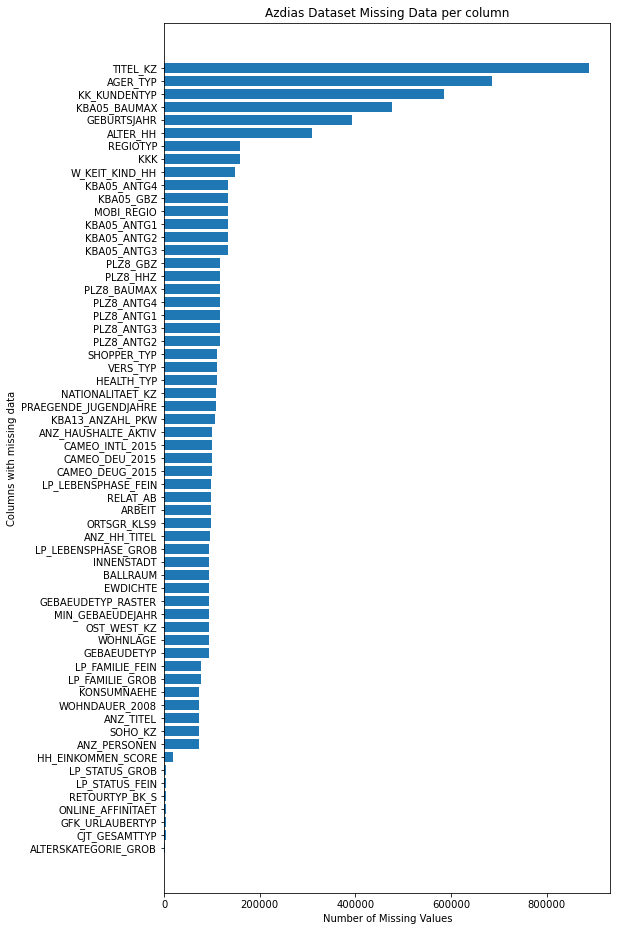

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nans = azdias.columns[azdias.isna().any()].tolist()
azdias_nans = azdias.loc[:, nans]

azdias_nans_idx = azdias_nans.isna().sum().sort_values(ascending=True).index
azdias_nans_sorted = azdias_nans[azdias_nans_idx]

plt.figure(figsize=[8, 16])
plt.barh(azdias_nans_sorted.columns, azdias_nans_sorted.isna().sum())
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns with missing data')
plt.title('Azdias Dataset Missing Data per column')
plt.tight_layout = True
plt.show()

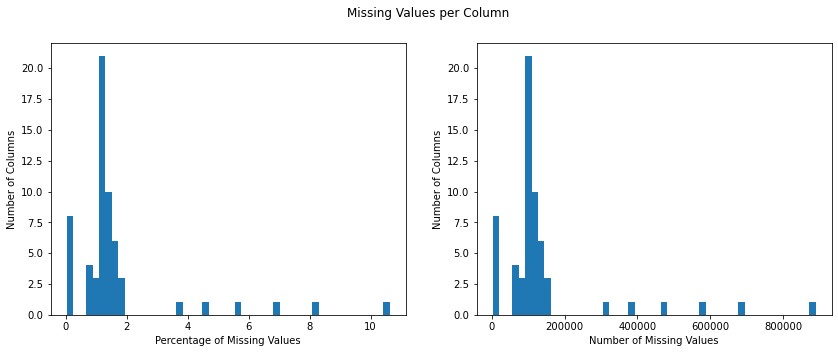

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=[14, 5])
plt.suptitle('Missing Values per Column')

plt.subplot(1, 2, 1)
percent_missing_per_column = (azdias_nans_sorted.isnull().sum() /
                             (azdias_nans_sorted.isnull().sum().sum()) * 100)
plt.hist(percent_missing_per_column, bins=50)
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')

plt.subplot(1, 2, 2)
x = azdias_nans_sorted.isnull().sum()
plt.hist(x, bins=50)
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Columns')
plt.show()

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
print('Number of Azdias columns before removing outliers is {}'.format(azdias.shape[1]))

azdias = azdias.loc[:, (azdias.isnull().sum(axis=0) <= 200000)]

print('Number of Azdias columns after removing outliers is {}'.format(azdias.shape[1]))

Number of Azdias columns before removing outliers is 85
Number of Azdias columns after removing outliers is 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

   Many of the columns in the Udacity_AZDIAS_Subset.csv dataset had both missing values and coded missing or unknown values. After converting all coded missing or unknown values to nans in the Azdias dataset, the amount of missing data per column could be plotted accurately. Looking at the results from plotting the amount of missing data per column in a bar and histogram plot showed that most of the columns with missing data were grouped together with a roughly similar amount of missing data. There were some clear outliers with far more missing values though. Since the majority of columns with missing values had less than 200,000 missing values and the outliers had around 300,000 to more than 800,000 missing values, I used greater than or equal to 200,000 missing values as the threshold to drop the outlier columns. The columns removed from the dataset were "AGER_TYP", "GEBURTSJAHR", "TITEL_KZ", "ALTER_HH", "KK_KUNDENTYP" and "KBA05_BAUMAX".

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

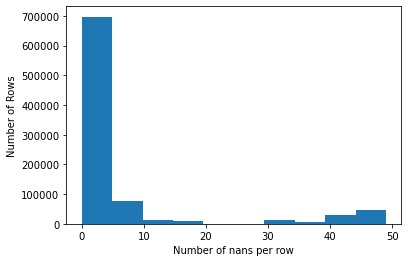

In [14]:
# How much data is missing in each row of the dataset?
nans_per_row = azdias.shape[1] - azdias.count(axis=1)

bins = np.arange(0, nans_per_row.max(), 5)
plt.hist(x=nans_per_row)
plt.xlabel('Number of nans per row')
plt.ylabel('Number of Rows');

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_low_nans = azdias.loc[azdias.isnull().sum(axis=1) <= 10].copy()

azdias_high_nans = azdias.loc[azdias.isnull().sum(axis=1) > 10].copy()

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot_comparison(df1, df2, column):
    fig, ax = plt.subplots(1, 2)
    plot_1 = sb.countplot(x=df1[column], ax=ax[0])
    plot_1.set(title="Few or no Missing Values")
    plot_2 = sb.countplot(x=df2[column], ax=ax[1])
    plot_2.set(title="Many Missing Values")
    fig.tight_layout()
    return

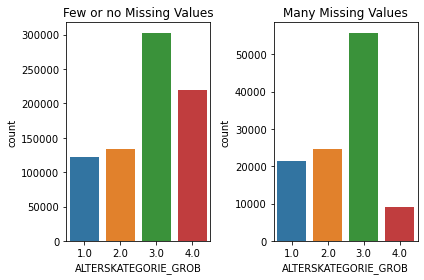

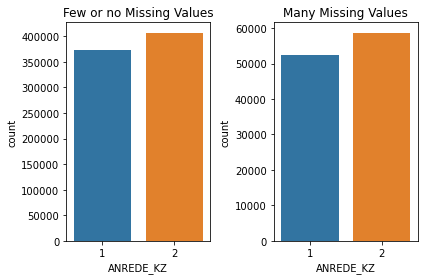

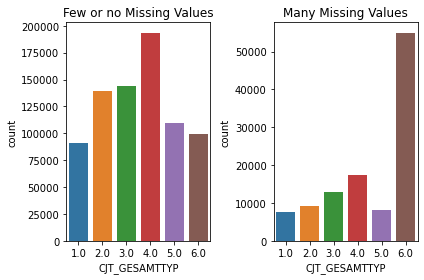

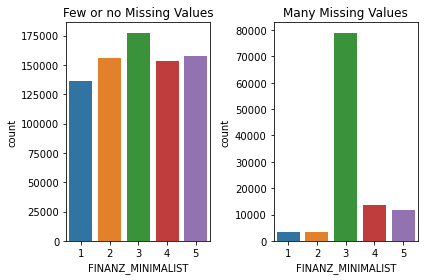

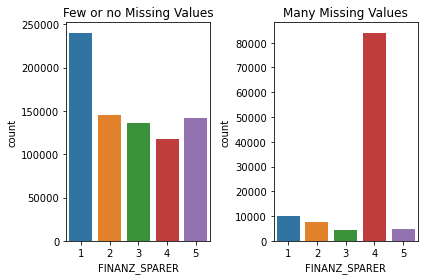

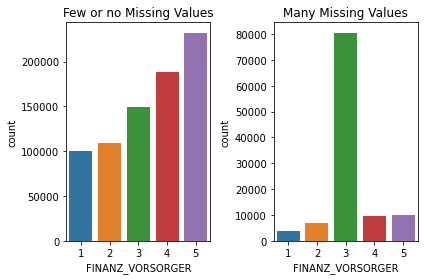

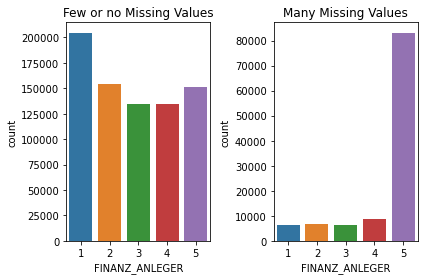

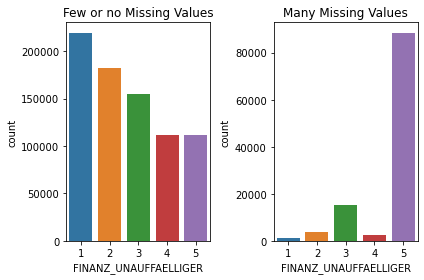

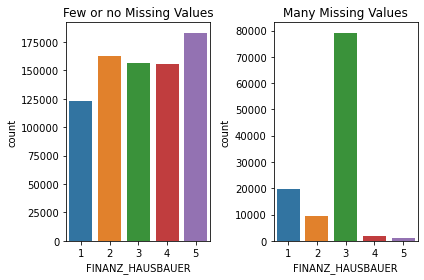

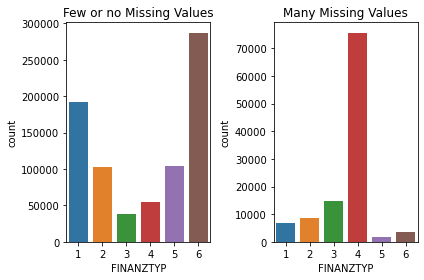

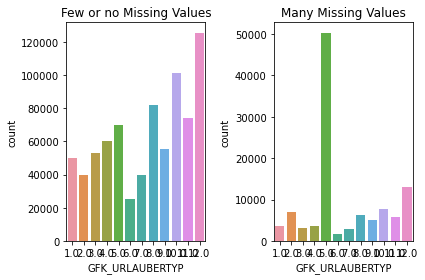

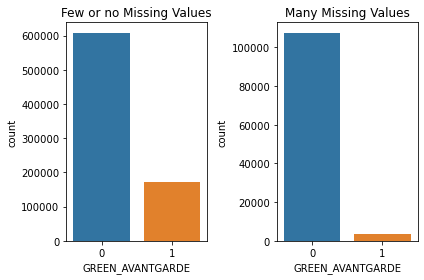

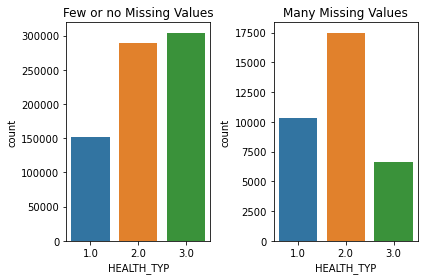

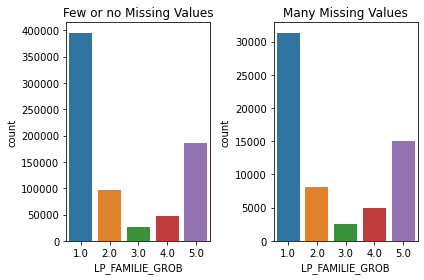

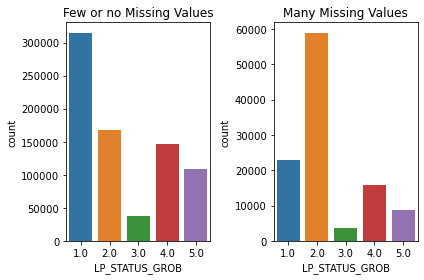

In [66]:
i = 1
for column in azdias_low_nans.columns:
    if i <= 15:
        plot_comparison(azdias_low_nans, azdias_high_nans, column)
        i += 1

#### Discussion 1.1.3: Assess Missing Data in Each Row

Looking at a histogram of missing values in the rows of the azdias dataset shows that the majority of rows had less than 10 missing values. I split the dataset into two subsets based on whether the rows had less than or equal to 10 or greater than 10 missing values per row. Plotting the distribution of each columns values in the two subsets side by side shows that the distribution of values looks both different and similar depending on which column is being looked at. Some columns like "ANREDE_KZ" look very similar between the two subsets, though the majority of columns seems to show a different distribution. Columns in the subset with less than 10 missing values such as "FINANZ_MINIMALIST" seem to have their values more evenly spread out, while in the subset with many missing values it often seems the case that one of the discrete values in the column represents the overwhelming majority of all that columns values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?

# Drop rows in feat_info that are not in azdias_low_nans dataset in order to count datatype and features
rows_to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ',
                'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

feat_info_dropped = feat_info[~feat_info.attribute.isin(rows_to_drop)]
feat_info_dropped.reset_index(drop=True, inplace=True)

# Identify different datatypes
datatypes = feat_info_dropped['type'].unique().tolist()

# Count datatypes, features, and unique feature values
for datatype in datatypes:
    datatype_index = feat_info_dropped.index[feat_info_dropped['type'] == datatype]
    datatype_value_count = azdias_low_nans.iloc[:, datatype_index].nunique(axis=0).sum()
    print("Datatype \"{}\" has {} features with a total of {} values in azdias_low_nans dataset\n"
          .format(datatype, len(datatype_index), datatype_value_count))

Datatype "ordinal" has 49 features with a total of 285 values in azdias_low_nans dataset

Datatype "categorical" has 18 features with a total of 138 values in azdias_low_nans dataset

Datatype "mixed" has 6 features with a total of 101 values in azdias_low_nans dataset

Datatype "numeric" has 6 features with a total of 1633 values in azdias_low_nans dataset



#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which ones needs to be re-encoded?
feat_cat_idx = feat_info_dropped.index[feat_info_dropped['type']=='categorical']
cat_idx = azdias_low_nans.iloc[:,feat_cat_idx]

print("Categorical Variables:")
for col in cat_idx:
  print(f"{col:20s} {azdias_low_nans[col].unique():}")

Categorical Variables:
ANREDE_KZ            [2 1]
CJT_GESAMTTYP        [ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP            [1 6 5 2 4 3]
GFK_URLAUBERTYP      [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
GREEN_AVANTGARDE     [0 1]
LP_FAMILIE_FEIN      [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB      [ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN       [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB       [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ     [ 1.  3.  2. nan]
SHOPPER_TYP          [ 3.  2.  1.  0. nan]
SOHO_KZ              [1. 0.]
VERS_TYP             [ 2.  1. nan]
ZABEOTYP             [5 3 4 1 6 2]
GEBAEUDETYP          [8. 1. 3. 2. 6. 4. 5.]
OST_WEST_KZ          ['W' 'O']
CAMEO_DEUG_2015      ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015       ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_low_nans['OST_WEST_KZ'].replace({'O': 0, 'W': 1}, inplace=True)

In [30]:
# List of redundant or unuseful columns to drop from dataset based off info in Data_Dictionary.md
columns_to_drop = ['LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN',
                   'HH_EINKOMMEN_SCORE', 'CAMEO_DEU_2015', 'MIN_GEBAEUDEJAHR', 'GEBAEUDETYP',
                   'PLZ8_BAUMAX', 'KBA13_ANZAHL_PKW']

azdias_low_nans.drop(columns_to_drop, axis=1, inplace=True)

In [31]:
# Locate categorical variables after dropping columns in azdias_low_nans
feat_info_dropped = feat_info_dropped[~feat_info_dropped.attribute.isin(columns_to_drop)]
feat_info_dropped.reset_index(drop=True, inplace=True)
feat_cat_idx = feat_info_dropped.index[feat_info_dropped['type']=="categorical"]
cat_idx = azdias_low_nans.iloc[:,feat_cat_idx]

# Create list of multi-level categorical columns to one-hot encode
print("Multi-level Categorical Variables to one-hot encode:")
multi_cat_encode = []
for i in azdias_low_nans.iloc[:,feat_cat_idx]:
    if azdias_low_nans[i].dropna().unique().shape[0] > 2:
        multi_cat_encode.append(i)
        print(i)

Multi-level Categorical Variables to one-hot encode:
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_GROB
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
ZABEOTYP
CAMEO_DEUG_2015


In [32]:
# One-hot encode multi-level categorical columns
azdias_encoded = pd.get_dummies(azdias_low_nans, columns=multi_cat_encode)
azdias_encoded.shape

(780153, 116)

#### Discussion 1.2.1: Re-Encode Categorical Features

Several columns were dropped in the dataset based on the information in Data_Dictionary.md. I dropped "LP_FAMILIE_FEIN", "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN" and "HH_EINKOMMEN_SCORE" as redundant categories as the data in "LP_FAMILIE_GROB", "CAMEO_INTL_2015" and "LP_STATUS_GROB" holds similar information. "CAMEO_DEU_2015" is dropped as "CAMEO_DEUG_2015" contains a more general form of similar data. "MIN_GEBAEUDEJAHR", "GEBAEUDETYP", "PLZ8_BAUMAX" and "KBA13_ANZAHL_PKW" are dropped as they don't seem particularly useful to group the populace and could dilute the categorization later.

The values of binary category 'OST_WEST_KZ' were transformed to 0 and 1 based values. Multi-level categories were identified and those that were kept were one-hot encoded. These steps will help ensure the data can be fit to the kmeans model later on properly.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
# Identify and locate Mixed-Type features
feat_mix_idx = feat_info_dropped.index[feat_info_dropped['type'] == "mixed"]
mix_idx = azdias_low_nans.iloc[:, feat_mix_idx]

print("Mixed-Type features:")
for col in mix_idx:
    print(f"{col:20s} {azdias_low_nans[col].unique():}")

Mixed-Type features:
PRAEGENDE_JUGENDJAHRE [14. 15.  8.  3. 10. 11.  5.  9.  6.  4. nan  2.  1. 12. 13.  7.]
WOHNLAGE             [4. 2. 7. 3. 5. 1. 8. 0.]
CAMEO_INTL_2015      ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25' nan
 '23' '31' '52' '35' '45' '44' '32']


In [34]:
# Create Mixed-Type variable encode function
def mixed_encode(df, column_to_encode, encoded_column_name, encoding_dictionary):
    df[encoded_column_name] = df[column_to_encode]
    df[encoded_column_name].replace(encoding_dictionary, inplace=True)
    return df

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
               8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

azdias_encoded = mixed_encode(azdias_encoded, 'PRAEGENDE_JUGENDJAHRE',
                              'PRAEGENDE_JUGENDJAHRE_DECADE', decade_dict)

movement_dict = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0,
                 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0}

azdias_encoded = mixed_encode(azdias_encoded, 'PRAEGENDE_JUGENDJAHRE',
                              'PRAEGENDE_JUGENDJAHRE_MOVEMENT', movement_dict)

In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth_dict = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,
               '31': 3, '32': 3, '33': 3, '34': 3, '35': 3, '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,
               '51': 5, '52': 5, '53': 5, '54': 5, '55': 5}

azdias_encoded = mixed_encode(azdias_encoded, 'CAMEO_INTL_2015',
                              'CAMEO_INTL_2015_WEALTH', wealth_dict)

life_stage_dict = {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5, '21': 1, '22': 2, '23': 3, '24': 4, '25': 5,
                   '31': 1, '32': 2,'33': 3, '34': 4, '35': 5, '41': 1, '42': 2, '43': 3, '44': 4, '45': 5, 
                   '51': 1, '52': 2, '53': 3, '54': 4, '55': 5}

azdias_encoded = mixed_encode(azdias_encoded, 'CAMEO_INTL_2015',
                              'CAMEO_INTL_2015_LIFE_STAGE', life_stage_dict)

In [37]:
# Encode Mixed Variable "WOHNLAGE"
neighborhood_dict = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 7: np.nan, 8: np.nan}

azdias_encoded = mixed_encode(azdias_encoded, 'WOHNLAGE',
                              'NEIGHBORHOOD_QUALITY', neighborhood_dict)

rural_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 7: 1, 8: 1}

azdias_encoded = mixed_encode(azdias_encoded, 'WOHNLAGE',
                              'RURAL_NEIGHBORHOOD', rural_dict)

#### Discussion 1.2.2: Engineer Mixed-Type Features

"PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015" and "WOHNLAGE" were mixed variables. Dictionaries were created for each of these variables in order to seperate and map the mixed type values into new variables. After these new columns were created and mapped, "PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015" and "WOHNLAGE" were dropped from the dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on in the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_encoded.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE'], inplace=True, axis=1)

In [40]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_encoded.reset_index(drop=True, inplace=True)
print(azdias_encoded.info())
azdias_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780153 entries, 0 to 780152
Columns: 119 entries, ALTERSKATEGORIE_GROB to RURAL_NEIGHBORHOOD
dtypes: float64(40), int64(23), uint8(56)
memory usage: 416.6 MB
None


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,NEIGHBORHOOD_QUALITY,RURAL_NEIGHBORHOOD
0,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,3.0,9.0,11.0,0.0,1.0,1,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,90.0,1.0,5.0,1.0,4.0,0.0
1,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,3.0,9.0,10.0,0.0,5.0,1,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,90.0,0.0,2.0,4.0,2.0,0.0
2,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,NaN,9.0,1.0,0.0,4.0,1,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,70.0,1.0,1.0,2.0,NaN,1.0
3,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,2.0,9.0,3.0,0.0,4.0,1,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,70.0,1.0,4.0,3.0,3.0,0.0
4,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,6.0,9.0,5.0,0.0,5.0,1,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,50.0,1.0,5.0,4.0,NaN,1.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [41]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for idx in range(feat_info.shape[0]):
        cd_mis_unk = feat_info.iloc[idx]['missing_or_unknown']
        cd_mis_unk = cd_mis_unk.strip('[]').split(sep=',')
        cd_mis_unk = [int(value) if (value != 'X' and value != 'XX' and value != '')
                      else value for value in cd_mis_unk]
        df = df.replace({feat_info.iloc[idx]['attribute']: cd_mis_unk}, np.nan)

    # remove selected columns and rows, ...
    columns_to_drop_1 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

    df.drop(columns_to_drop_1, inplace=True, axis=1)

    df_low_nan = df.loc[df.isnull().sum(axis=1) <= 10].copy()

    df_high_nan = df.loc[df.isnull().sum(axis=1) > 10].copy()

    columns_to_drop_2 = ['LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN',
                         'HH_EINKOMMEN_SCORE', 'CAMEO_DEU_2015', 'MIN_GEBAEUDEJAHR', 'GEBAEUDETYP',
                         'PLZ8_BAUMAX', 'KBA13_ANZAHL_PKW']

    df_low_nan.drop(columns_to_drop_2, inplace=True, axis=1)

    # select, re-encode, and engineer column values.
    df_low_nan['OST_WEST_KZ'].replace({'O': 0, 'W': 1}, inplace=True)

    multi_cat_encode = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                        'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015']

    df_low_nan = pd.get_dummies(df_low_nan, columns=multi_cat_encode)

    decade_dict = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
                   8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}

    movement_dict = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0,
                     8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0}

    wealth_dict = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '21': 2, '22': 2, '23': 2, '24': 2, '25': 2,
                   '31': 3, '32': 3, '33': 3, '34': 3, '35': 3, '41': 4, '42': 4, '43': 4, '44': 4, '45': 4,
                   '51': 5, '52': 5, '53': 5, '54': 5, '55': 5}

    life_stage_dict = {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5, '21': 1, '22': 2, '23': 3, '24': 4, '25': 5,
                       '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, '41': 1, '42': 2, '43': 3, '44': 4, '45': 5,
                       '51': 1, '52': 2, '53': 3, '54': 4, '55': 5}

    neighborhood_dict = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 7: np.nan, 8: np.nan}

    rural_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 7: 1, 8: 1}

    df_low_nan = mixed_encode(df_low_nan, 'PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_DECADE', decade_dict)

    df_low_nan = mixed_encode(df_low_nan, 'PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT', movement_dict)

    df_low_nan = mixed_encode(df_low_nan, 'CAMEO_INTL_2015', 'CAMEO_INTL_2015_WEALTH', wealth_dict)

    df_low_nan = mixed_encode(df_low_nan, 'CAMEO_INTL_2015', 'CAMEO_INTL_2015_LIFE_STAGE', life_stage_dict)

    df_low_nan = mixed_encode(df_low_nan, 'WOHNLAGE', 'NEIGHBORHOOD_QUALITY', neighborhood_dict)

    df_low_nan = mixed_encode(df_low_nan, 'WOHNLAGE', 'RURAL_NEIGHBORHOOD', rural_dict)

    df_low_nan.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE'], inplace=True, axis=1)

    # Return the cleaned dataframe.s
    df_low_nan.reset_index(drop=True, inplace=True)
    df_high_nan.reset_index(drop=True, inplace=True)

    return df_low_nan, df_high_nan

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# fit and transform the dataset by filling NaN values
azdias_imp = imputer.fit_transform(azdias_encoded)

In [43]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

azdias_scaled = scaler.fit_transform(azdias_imp)

### Discussion 2.1: Apply Feature Scaling

Since the previous cleaning steps removed the columns and rows with the most nans, I wanted to keep the data that remained. I decided to use imputation, converting all nans to the most frequent value in the columns they were in. This allowed me to keep and scale all the data. One side effect of having converted the nans to the most frequent values in each column is that the dataset will contain an even greater percentage of those most frequent values. The benefits of keeping the data in order to have more datapoints to cluster the population seem to outweigh the slight disproportion of the most frequent values.

After imputation, feature scaling of all values is performed using sklearn's StandarScaler class. This standardization of the data to a mean of 0 and standard deviation of 1 allows the data to be clustered properly by normalizing the data and removing the bias towards very large or very small feature scales.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [45]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit(azdias_scaled)

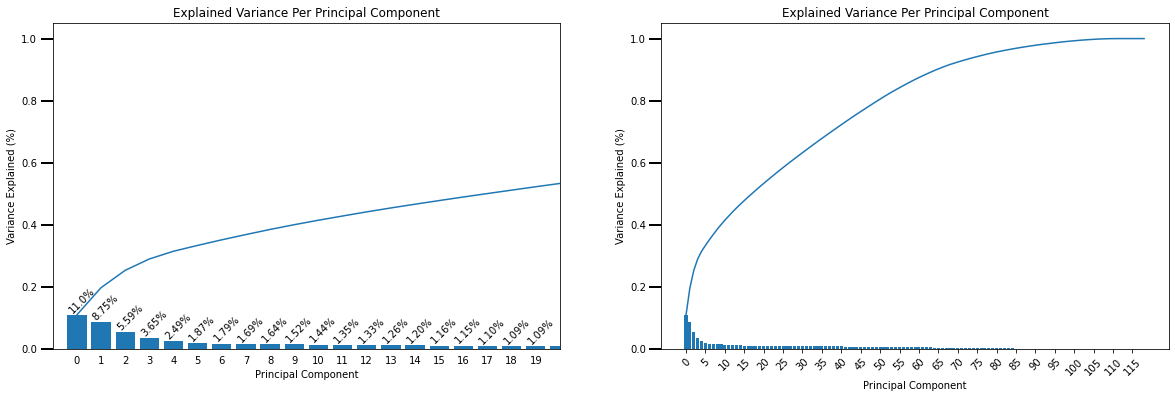

In [46]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(121)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", rotation = 45)
    plt.xlim(-1,20)
    plt.xticks(range(0,20));
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    ax = plt.subplot(122)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    plt.xticks(range(0,num_components, 5))
    ax.xaxis.set_tick_params(rotation = 45)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=63)
azdias_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

After performing PCA on the entire cleaned dataset using all the features, plotting the variance explained per component sequentially and cumulatively gave some insight into the number of components to keep. I chose to use 63 components as this accounts for almost 90% of the variance in the data. This reduced the dimensionality of the dataset from 119 to 63 dimensions.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [49]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def get_weights(n):
    weights_df = pd.DataFrame(pca.components_,columns=list(azdias_encoded.columns)).iloc[n].sort_values(ascending = False)
    print("Highest weighted:\n{}\n\nLowest Weighted:\n{}".format(weights_df.head(), weights_df.tail()))
    
   
get_weights(0)

Highest weighted:
LP_STATUS_GROB_1.0        0.200624
PLZ8_ANTG3                0.189327
PLZ8_ANTG4                0.182096
CAMEO_INTL_2015_WEALTH    0.180865
ORTSGR_KLS9               0.165948
Name: 0, dtype: float64

Lowest Weighted:
KBA05_GBZ           -0.183863
KBA05_ANTG1         -0.186785
PLZ8_ANTG1          -0.188091
MOBI_REGIO          -0.196844
FINANZ_MINIMALIST   -0.214001
Name: 0, dtype: float64


In [50]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_weights(1)

Highest weighted:
ALTERSKATEGORIE_GROB    0.217260
FINANZ_VORSORGER        0.202607
ZABEOTYP_3              0.200631
SEMIO_ERL               0.182269
SEMIO_LUST              0.152885
Name: 1, dtype: float64

Lowest Weighted:
SEMIO_TRADV                    -0.197879
FINANZ_SPARER                  -0.200924
FINANZ_UNAUFFAELLIGER          -0.202659
SEMIO_REL                      -0.206841
PRAEGENDE_JUGENDJAHRE_DECADE   -0.213417
Name: 1, dtype: float64


In [51]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_weights(2)

Highest weighted:
SEMIO_VERT     0.326766
SEMIO_SOZ      0.258551
SEMIO_FAM      0.257621
SEMIO_KULT     0.245636
FINANZTYP_5    0.140425
Name: 2, dtype: float64

Lowest Weighted:
SEMIO_ERL    -0.198039
SEMIO_KRIT   -0.268843
SEMIO_DOM    -0.294726
SEMIO_KAEM   -0.323292
ANREDE_KZ    -0.352147
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

The first component has high positive correlations between LP_STATUS_GROB_1.0, PLZ8_ANTG3, and PLZ8_ANTG4 and high negative correlations with FINANZ_MINIMALIST, MOBI_REGIO and PLZ8_ANTG1. The high negative correlation between LP_STATUS_GROB_1.0 and FINANZ_MINIMALIST is indicative that the less an individual is a FINANZ_MINIMALIST the less likely they are to be a low income earner. It makes sense that PLZ8_ANTG3 and PLZ8_ANTG4 positively correspond with each other as these features refer to the number of 6-10 family homes and 10+ family homes in the PLZ8 Region, respectively. It also seems intuitive that PLZ8_ANTG1, which correspond to 1-2 family houses in the PLZ8 region, is inversely related to the 6+ family houses categories. Those who live in 6-10 and 10+ family homes may share similar low-income financial situations and characteristics different from those who live in 1-2 family homes.

The second component has some interesting correlations. ALTERSKATEGORIE_GROB and PRAEGENDE_JUGENDJAHRE_DECADE are inversely related to each other. As PRAEGENDE_JUGENDJAHRE, or decade of a persons youth increases from the 40s to the 90s, ALTERSKATEGORIE_GROB or a persons estimated age decreases. This makes perfect sense, though it is interesting to see in the data. FINANZ_VORSORGER (preparedness) is inversely related to FINANZ_UNAUFFAELLIGER (inconspicuous) and FINANZ_SPARER (Money Saver). This could be due to different spending habits of those in FINANZ_VORSORGER compared to those in FINANZ_UNAUFFAELLIGER and FINANZ_SPARER.

The third component seems to correspond to personality type and possible gender differences. Andrede KZ (gender) is negatively correlated with SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT. In the data dictionary, these correspond respectively to personality types dreamful, socially-minded, family-minded and cultural-minded. These are all negatively correlated with SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL and SEMIO_RAT which are personality types combative attitude, dominant-minded, critical-minded, event-oriented and rational, respectively.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

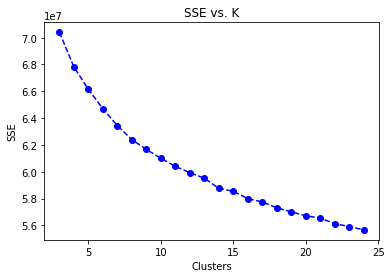

In [55]:
# Investigate the change in within-cluster distance across number of clusters.
OMP_NUM_THREADS = 16


def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center, n_init=7, max_iter=300)

    # Then fit the model to the data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

# Investigate the change in within-cluster distance across number of clusters.
scores = []
centers = list(range(3, 25))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.title('SSE vs. K');

In [56]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
#from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=14, n_init=20, random_state=42)

kmeans_model = kmeans.fit(azdias_pca)

gen_pop_pred = kmeans_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

After iterating over 22 Kmeans cluster counts from 3 to 24 clusters and plotting the resulting fitted cluster's SSE (Sum of Squared Error) score, I chose to use 14 clusters as the best fit to segment the population data. There is an elbow in the SSE vs Cluster plot at 14 clusters after which more clusters didn't substantially reduce the SSE score.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [57]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [58]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# clean customer data using cleaning function created earlier
customers_low_nan, customers_high_nan = clean_data(customers)

# transform the dataset by filling nan values using imputer object from general population data
customers_imp = imputer.transform(customers_low_nan)

# apply feature scaling to the customer demographics data using scaler object from general population data
customers_scaled = scaler.transform(customers_imp)

# apply pca to the customer demographics data using pca object from general population data
customers_pca = pca.transform(customers_scaled)

# obtain cluster predictions for the customer demographics data using fitted kmeans model from general population data
customers_pred = kmeans_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

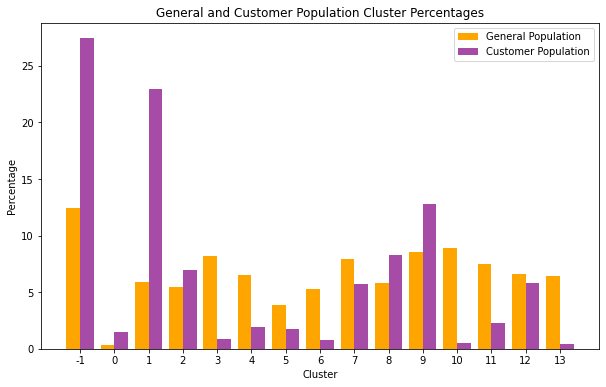

In [59]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
gen_pop_pred_dict = Counter(gen_pop_pred)
gen_pop_pred_dict[-1] = azdias_high_nans.shape[0]
gen_pop_pred_dict = sorted(gen_pop_pred_dict.items())
customers_pred_dict = Counter(customers_pred)
customers_pred_dict[-1] = customers_high_nan.shape[0]
customers_pred_dict = sorted(customers_pred_dict.items())

labels = [l for l, v in gen_pop_pred_dict]
v = [v for l, v in gen_pop_pred_dict]
v = [x/(len(gen_pop_pred) + azdias_high_nans.shape[0]) * 100 for x in v]
v1 = [v for l, v in customers_pred_dict]
v1 = [x/(len(customers_pred) + customers_high_nan.shape[0]) * 100 for x in v1]
indexes = np.arange(len(labels))
width = 0.4

plt.figure(figsize=[10, 6])
plt.title('General and Customer Population Cluster Percentages')
plt.bar(indexes, v, width, color='orange', label='General Population')
plt.bar(indexes+width, v1, width, color='purple', label='Customer Population', alpha=0.7)
plt.xticks(indexes + width * 0.5, labels)
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(loc='upper right')
plt.show()

In [60]:
# Dataframe of original dataset mean values per cluster using pca and scaler inverse_transform
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans_model.cluster_centers_)),
                             columns=customers_low_nan.columns)
cluster_specs.index.name = "Cluster"

cluster_specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,NEIGHBORHOOD_QUALITY,RURAL_NEIGHBORHOOD
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.180390,1.462476,3.503728,2.276886,3.884920,2.219126,2.444813,2.873920,0.733596,1.888159,4.527889,4.049326,4.053985,3.385194,3.718719,4.644608,4.658370,4.865866,3.565284,3.379475,4.445922,4.130875,4.222047,3.293836,3.496755,-0.011146,1.679164,1.979139,0.866116,4.684905,8.815527,26.342384,2.350091,3.353741,0.873695,1.215819,1.328005,0.302864,0.422112,3.011535,3.102818,4.688878,3.459781,4.289358,1.929921,2.627904,2.328063,3.041266,1.881088,3.270872,1.884008,0.836632,3.853846,3.303491,3.072352,5.978928,3.118282,0.176077,0.225229,0.061556,0.210086,0.154715,0.162234,0.312911,0.173035,-0.092844,0.028778,0.227365,0.350756,0.076014,0.054819,0.089351,0.092978,0.084591,0.014478,0.015422,0.086222,0.121211,0.143690,0.060084,0.151037,0.552069,0.162207,-0.015588,-0.050183,0.333341,-0.122349,-0.008250,1.113644,0.136782,-0.129930,0.848991,0.055621,0.038627,0.079793,0.306028,0.255278,0.294646,0.224169,0.316441,0.303943,0.159458,0.010997,-0.015008,0.204404,0.059188,0.061015,0.070086,0.148509,0.121434,0.114069,0.127898,0.085416,68.891324,0.266404,2.974550,3.358937,3.690773,0.250934
1,3.278869,1.051148,4.756661,1.544795,4.438276,1.426354,1.974416,2.090942,0.991911,2.070403,3.864506,5.246173,4.830985,3.781315,3.809380,6.225685,5.348980,4.073896,4.947121,2.722949,3.056577,3.355112,2.622629,3.259976,3.258188,0.007938,1.506058,2.240353,0.002312,4.335119,8.627693,1.760827,-0.003696,3.413611,0.921245,2.807151,1.036838,0.079399,0.007068,4.150684,4.112594,3.988040,4.651872,3.982076,2.154833,4.210056,3.208162,3.516787,2.813899,2.546172,1.166643,0.375526,3.661816,3.886587,3.000033,5.377115,2.918546,0.176267,0.201950,0.249749,0.181646,0.106075,0.076686,-0.026130,0.183226,0.025996,0.019954,0.383601,0.413354,0.067432,0.032899,0.099434,0.083755,0.155875,0.050436,0.098872,0.147067,0.033750,0.136792,0.044250,0.041812,0.294691,0.195135,0.018397,0.096263,0.359042,0.051040,0.058268,0.090710,0.030715,0.761641,0.961555,0.035371,0.011100,0.284228,0.337240,0.136047,0.249530,0.575205,0.069731,0.248086,0.077024,-0.019792,0.049745,0.150760,0.262254,0.152516,0.173

In [61]:
# Get top 4 PCA compnents for a particular cluster
def top_4_pca(cluster):
    pca_vector = pd.Series(kmeans.cluster_centers_[cluster]).sort_values(ascending = False)
    print("Cluster {}\nTop PCA Components:\n{}".format(cluster, pca_vector.head(4)))
    

# Top PCA Components for Cluster 1
top_4_pca(1)

Cluster 1
Top PCA Components:
2     2.997142
3     2.650118
11    0.329500
47    0.277105
dtype: float64


In [62]:
# PCA Component 2 Variable Weights
get_weights(2)

Highest weighted:
SEMIO_VERT     0.326766
SEMIO_SOZ      0.258551
SEMIO_FAM      0.257621
SEMIO_KULT     0.245636
FINANZTYP_5    0.140425
Name: 2, dtype: float64

Lowest Weighted:
SEMIO_ERL    -0.198039
SEMIO_KRIT   -0.268843
SEMIO_DOM    -0.294726
SEMIO_KAEM   -0.323292
ANREDE_KZ    -0.352147
Name: 2, dtype: float64


In [63]:
# PCA Component 3 Variable Weights
get_weights(3)

Highest weighted:
GREEN_AVANTGARDE      0.344796
LP_STATUS_GROB_5.0    0.269120
EWDICHTE              0.232135
ORTSGR_KLS9           0.226926
ONLINE_AFFINITAET     0.138617
Name: 3, dtype: float64

Lowest Weighted:
INNENSTADT                       -0.184429
BALLRAUM                         -0.195132
KKK                              -0.204325
RURAL_NEIGHBORHOOD               -0.211518
PRAEGENDE_JUGENDJAHRE_MOVEMENT   -0.344796
Name: 3, dtype: float64


In [67]:
# Top PCA Components for Cluster 9
top_4_pca(9)

Cluster 9
Top PCA Components:
2     1.640756
4     0.495168
13    0.424282
7     0.363306
dtype: float64


In [80]:
# PCA Component 2 Variable Weights
get_weights(4)

Highest weighted:
ANZ_PERSONEN           0.340754
LP_FAMILIE_GROB_5.0    0.278985
KKK                    0.227565
FINANZTYP_6            0.209317
ONLINE_AFFINITAET      0.191665
Name: 4, dtype: float64

Lowest Weighted:
OST_WEST_KZ           -0.142478
PLZ8_GBZ              -0.145336
LP_STATUS_GROB_2.0    -0.155731
W_KEIT_KIND_HH        -0.316787
LP_FAMILIE_GROB_1.0   -0.338476
Name: 4, dtype: float64


# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

Clusters 1, -1 and 9 have a high proportion of customers compared to the general population, meaning the people in these clusters are a target audience for the company.

Cluster 1 is made up of predominantly males who are 46-60 years old. They are not finance minimalists, but are money-savers and investors. These people are home owners with high levels of income who have a prosperous household. They are most likely an older family or mature couple from west Germany. They have rational, critical and combative attitudes and low social and very low dreamful type personalities. They also have a high online affinity.

The cluster -1 with high missing values in the original dataset turns out to have a high proportion of customers compared to the general population as well. The people in this cluster consist of mostly 46-60 year olds and there is about an equal male and female ratio in the cluster. There is a high affinity to take nature vacations amongst people in this cluster and they have a very high affinity to be socially minded and dreamful. They are mostly middle class from West Germany who have an average amount of income.

Cluster 9 contains many customers as well. This cluster consists of mostly male 46-60 year old who have rational and combative attitudes and don't have dreamful type personalities. They are homeowners with prosperous households and most likely have school age children.

In [68]:
# Top PCA Components for Cluster 10
top_4_pca(10)

Cluster 10
Top PCA Components:
0     5.253949
3     0.375851
14    0.223183
16    0.186595
dtype: float64


In [79]:
# PCA Component 0 Variable Weights
get_weights(0)

Highest weighted:
LP_STATUS_GROB_1.0        0.200624
PLZ8_ANTG3                0.189327
PLZ8_ANTG4                0.182096
CAMEO_INTL_2015_WEALTH    0.180865
ORTSGR_KLS9               0.165948
Name: 0, dtype: float64

Lowest Weighted:
KBA05_GBZ           -0.183863
KBA05_ANTG1         -0.186785
PLZ8_ANTG1          -0.188091
MOBI_REGIO          -0.196844
FINANZ_MINIMALIST   -0.214001
Name: 0, dtype: float64


In [72]:
# Top PCA Components for Cluster 3
top_4_pca(3)

Cluster 3
Top PCA Components:
8     0.461062
15    0.458778
13    0.289758
18    0.269230
dtype: float64


In [75]:
# PCA Component 8 Variable Weights
get_weights(8)

Highest weighted:
ZABEOTYP_6              0.267438
SEMIO_MAT               0.239579
NATIONALITAET_KZ_2.0    0.194544
SEMIO_RAT               0.159845
SEMIO_TRADV             0.158384
Name: 8, dtype: float64

Lowest Weighted:
LP_FAMILIE_GROB_1.0     -0.148444
FINANZ_UNAUFFAELLIGER   -0.157319
REGIOTYP                -0.204306
NATIONALITAET_KZ_1.0    -0.213121
KKK                     -0.219759
Name: 8, dtype: float64


In [76]:
# PCA Component 15 Variable Weights
get_weights(15)

Highest weighted:
LP_STATUS_GROB_2.0    0.403940
KKK                   0.251252
SHOPPER_TYP_1.0       0.244447
REGIOTYP              0.239243
GREEN_AVANTGARDE      0.181591
Name: 15, dtype: float64

Lowest Weighted:
LP_STATUS_GROB_1.0               -0.143685
SHOPPER_TYP_3.0                  -0.168975
CJT_GESAMTTYP_3.0                -0.173684
PRAEGENDE_JUGENDJAHRE_MOVEMENT   -0.181591
LP_STATUS_GROB_4.0               -0.330098
Name: 15, dtype: float64


In [78]:
# Top PCA Components for Cluster 3
top_4_pca(13)

Cluster 13
Top PCA Components:
0     5.076238
2     2.623552
21    0.467788
5     0.452252
dtype: float64


# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

Clusters 10, 3 and 13 have low proportions of customers compared to the general population so they are outside of the target demographics for the company.

Cluster 10 is made up of middle aged and younger females who are finance minimalists. There is a high affinity of dreamful and sensually minded personality types and a low affinity of dominate, combative and critically minded personality types for people in this cluster. They are mostly single or young couples with children and are of the working class with less affluent households and a lower income.

Cluster 3 has many 30-45 year old females who are dreamful, socially and sensually minded with a high to very high online affinity. They have families with school age children and have average to low income. 

Cluster 13 consists of male 30-45 year olds who are event oriented and combative, dominant and sensually minded. They are low income earners of less affluent households who are predominantly finance minimalist. They are also mostly single or a young couple with children.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.